# Libraries

In [35]:
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score,
    KFold
)
from optuna.visualization import (
    plot_optimization_history, 
    plot_param_importances, 
    plot_slice
)
from sklearn import set_config
#from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from tqdm import tqdm

import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import optuna
import shap

# Configuration

In [2]:
# Global configurations for sklearn:
set_config(transform_output="pandas")

# Global configurations for pandas:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)
pd.set_option("display.precision", 3)
pd.set_option("display.max_colwidth", None)

In [3]:
SEED = 42

DATA_DIR = 'data/'

# Functions

In [4]:
def test_func():
    pass

# Read data

In [5]:
# Original data
org_data = pd.read_csv(DATA_DIR + 'flood.csv')

# Competition data
org_train = pd.read_csv(DATA_DIR + 'train.csv')

In [6]:
# Enrich dataset
org_train.drop('id', axis=1, inplace=True)
df_master = pd.concat([org_train, org_data])

# Leave the original data as is
df = df_master.copy()
df.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5,0.415


# EDA

In [7]:
print(f'Before concat: {org_train.shape}, {org_data.shape}\n')
print(f'After concat: {df_master.shape}, {df.shape}')

Before concat: (1117957, 21), (50000, 21)

After concat: (1167957, 21), (1167957, 21)


In [8]:
# View columns stats
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1167957 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   MonsoonIntensity                 1167957 non-null  int64  
 1   TopographyDrainage               1167957 non-null  int64  
 2   RiverManagement                  1167957 non-null  int64  
 3   Deforestation                    1167957 non-null  int64  
 4   Urbanization                     1167957 non-null  int64  
 5   ClimateChange                    1167957 non-null  int64  
 6   DamsQuality                      1167957 non-null  int64  
 7   Siltation                        1167957 non-null  int64  
 8   AgriculturalPractices            1167957 non-null  int64  
 9   Encroachments                    1167957 non-null  int64  
 10  IneffectiveDisasterPreparedness  1167957 non-null  int64  
 11  DrainageSystems                  1167957 non-null  int64 

## Null & Duplicates

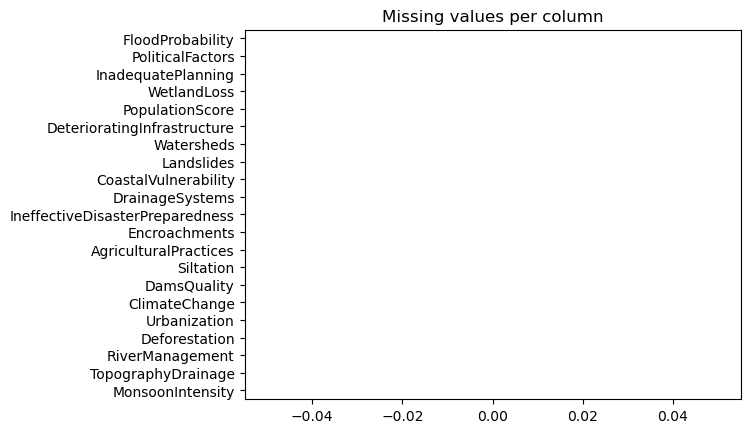

In [9]:
# Check for missing values with a horizontal bar plot
df.isnull().sum().plot(kind='barh')
plt.title('Missing values per column')
plt.show()

In [10]:
# Check for duplication
print(f'Number of duplicated records: {df.duplicated().sum()}')

Number of duplicated records: 0


## Numerical

In [11]:
# Select only numerical
numerical_columns = list(df.select_dtypes(include=['float64', 'int64']))

In [12]:
# Check statistics
df[numerical_columns].describe().round(3)

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.168e+06,1.168e+06,1.168e+06,1.168e+06,1.168e+06,1.168e+06,1.168e+06,1.168e+06,1.168e+06,1.168e+06,1.168e+06,1.168e+06,1.168e+06,1.168e+06,1.168e+06,1.168e+06,1.168e+06,1.168e+06,1.168e+06,1.168e+06,1.168e+06
mean,4.924e+00,4.929e+00,4.958e+00,4.945e+00,4.945e+00,4.936e+00,4.958e+00,4.930e+00,4.945e+00,4.952e+00,4.948e+00,4.949e+00,4.956e+00,4.934e+00,4.931e+00,4.929e+00,4.930e+00,4.953e+00,4.943e+00,4.941e+00,5.040e-01
std,2.064e+00,2.101e+00,2.079e+00,2.059e+00,2.091e+00,2.065e+00,2.090e+00,2.073e+00,2.076e+00,2.090e+00,2.085e+00,2.080e+00,2.096e+00,2.085e+00,2.089e+00,2.072e+00,2.081e+00,2.076e+00,2.088e+00,2.097e+00,5.100e-02
min,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,2.850e-01
25%,3.000e+00,3.000e+00,4.000e+00,4.000e+00,3.000e+00,3.000e+00,4.000e+00,3.000e+00,3.000e+00,4.000e+00,3.000e+00,4.000e+00,3.000e+00,3.000e+00,3.000e+00,3.000e+00,3.000e+00,3.000e+00,3.000e+00,3.000e+00,4.700e-01
50%,5.000e+00,5.000e+00,5.000e+00,5.000e+00,5.000e+00,5.000e+00,5.000e+00,5.000e+00,5.000e+00,5.000e+00,5.000e+00,5.000e+00,5.000e+00,5.000e+00,5.000e+00,5.000e+00,5.000e+00,5.000e+00,5.000e+00,5.000e+00,5.050e-01
75%,6.000e+00,6.000e+00,6.000e+00,6.000e+00,6.000e+00,6.000e+00,6.000e+00,6.000e+00,6.000e+00,6.000e+00,6.000e+00,6.000e+00,6.000e+00,6.000e+00,6.000e+00,6.000e+00,6.000e+00,6.000e+00,6.000e+00,6.000e+00,5.400e-01
max,1.600e+01,1.800e+01,1.600e+01,1.700e+01,1.700e+01,1.700e+01,1.600e+01,1.600e+01,1.600e+01,1.800e+01,1.600e+01,1.700e+01,1.700e+01,1.600e+01,1.600e+01,1.700e+01,1.900e+01,2.200e+01,1.600e+01,1.600e+01,7.250e-01


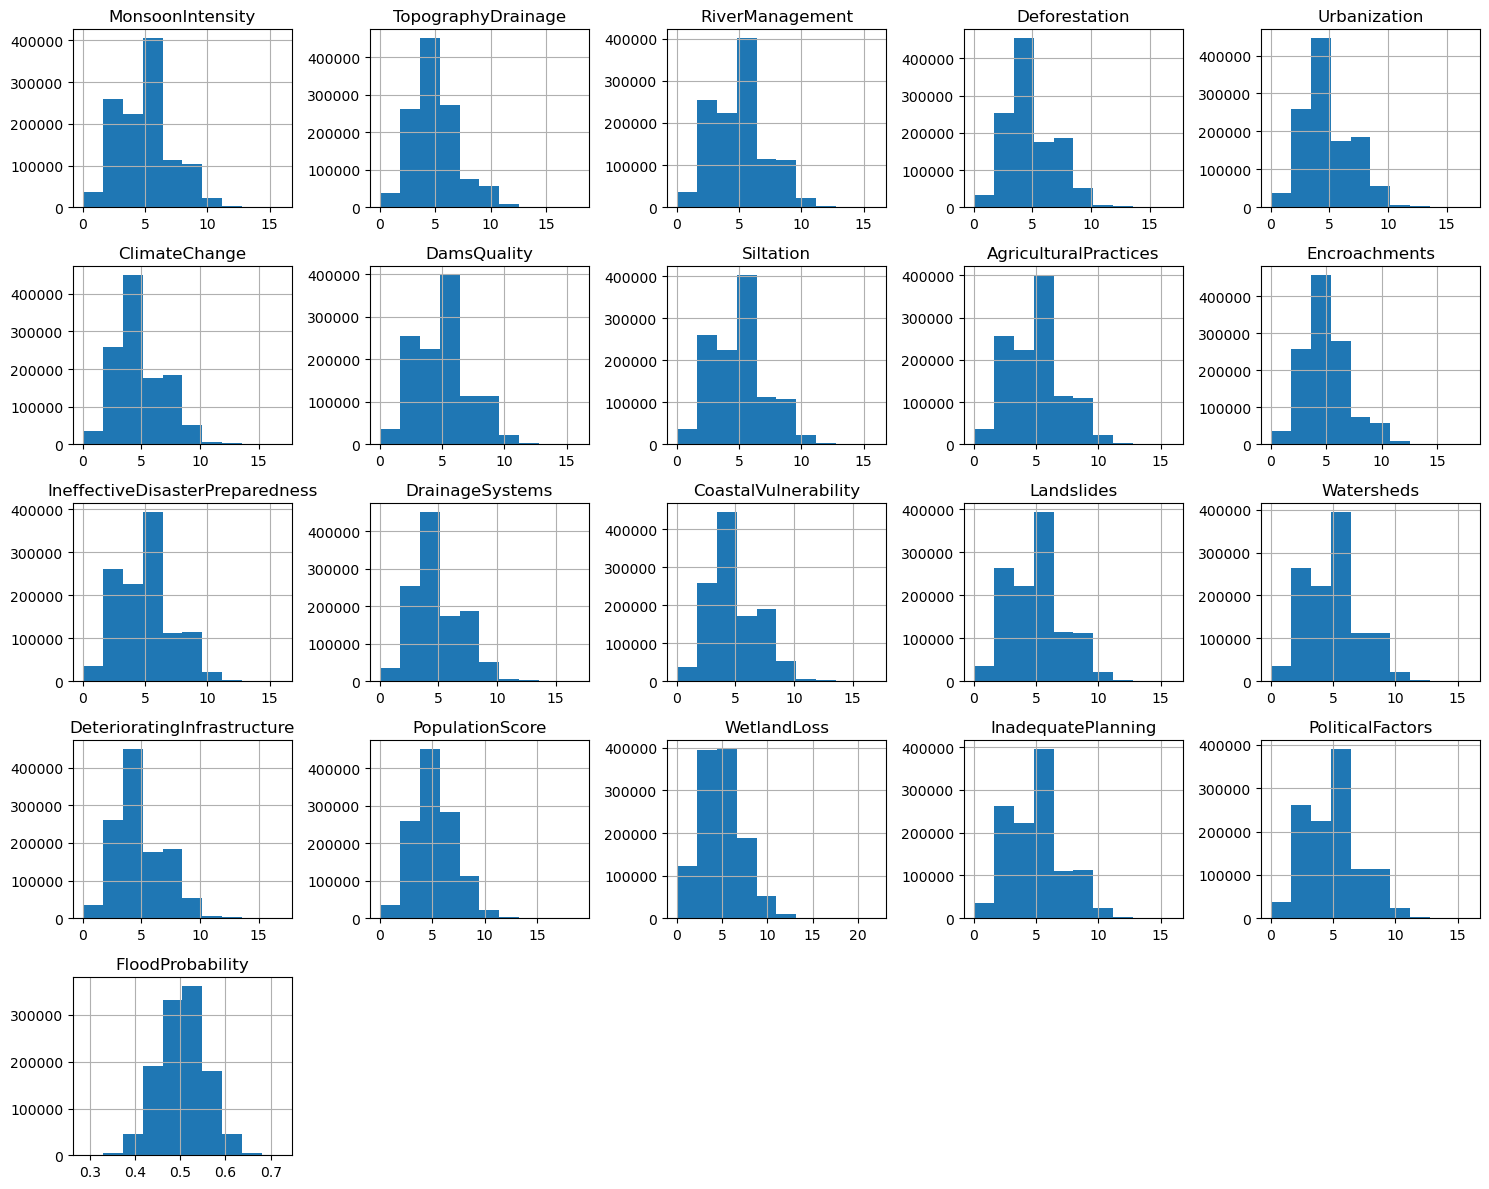

In [13]:
df.hist(figsize=(15, 12))
plt.title("Numerical features distribution with Histograms")
plt.tight_layout()
plt.show()

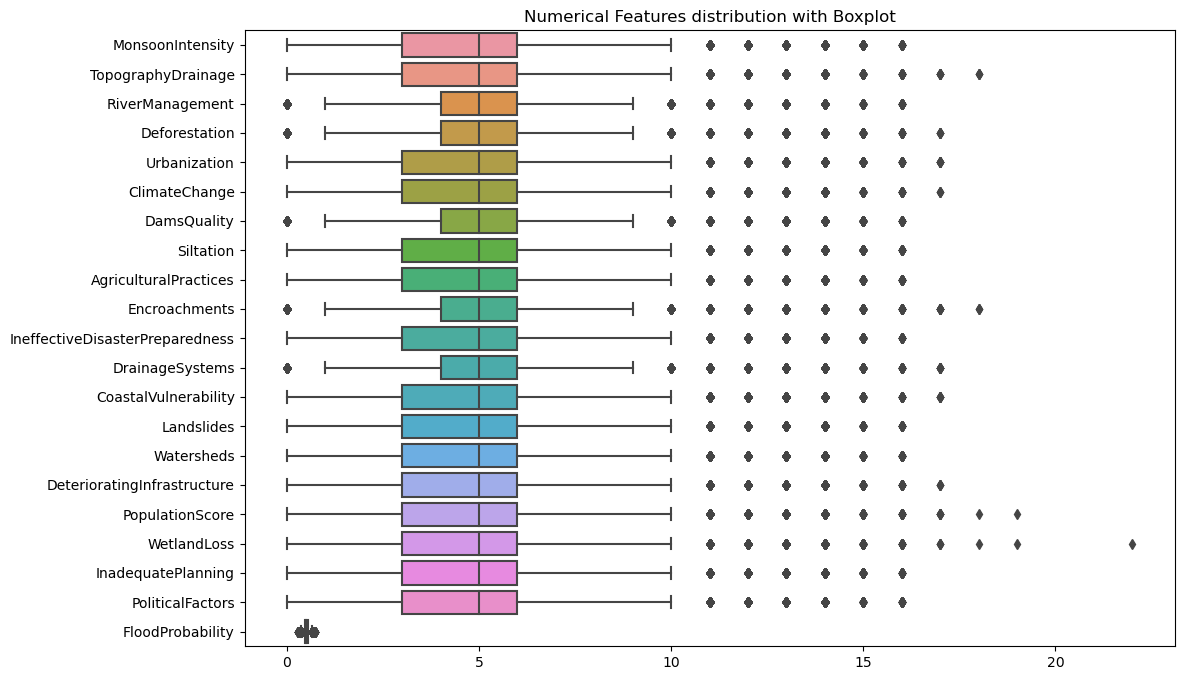

In [14]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[numerical_columns], orient='h')
plt.title('Numerical Features distribution with Boxplot')
plt.show()

In [15]:
skew_coefficients = df[numerical_columns].skew()
skew_coefficients

MonsoonIntensity                   0.445
TopographyDrainage                 0.460
RiverManagement                    0.428
Deforestation                      0.436
Urbanization                       0.444
ClimateChange                      0.431
DamsQuality                        0.442
Siltation                          0.451
AgriculturalPractices              0.422
Encroachments                      0.464
IneffectiveDisasterPreparedness    0.444
DrainageSystems                    0.443
CoastalVulnerability               0.441
Landslides                         0.426
Watersheds                         0.452
DeterioratingInfrastructure        0.445
PopulationScore                    0.453
WetlandLoss                        0.438
InadequatePlanning                 0.456
PoliticalFactors                   0.439
FloodProbability                   0.050
dtype: float64

In [16]:
# Check for inf values
for column in df.columns:
    if np.isinf(df[column]).any():
        print(f"Column '{column}' contains inf values.")

## Relationship

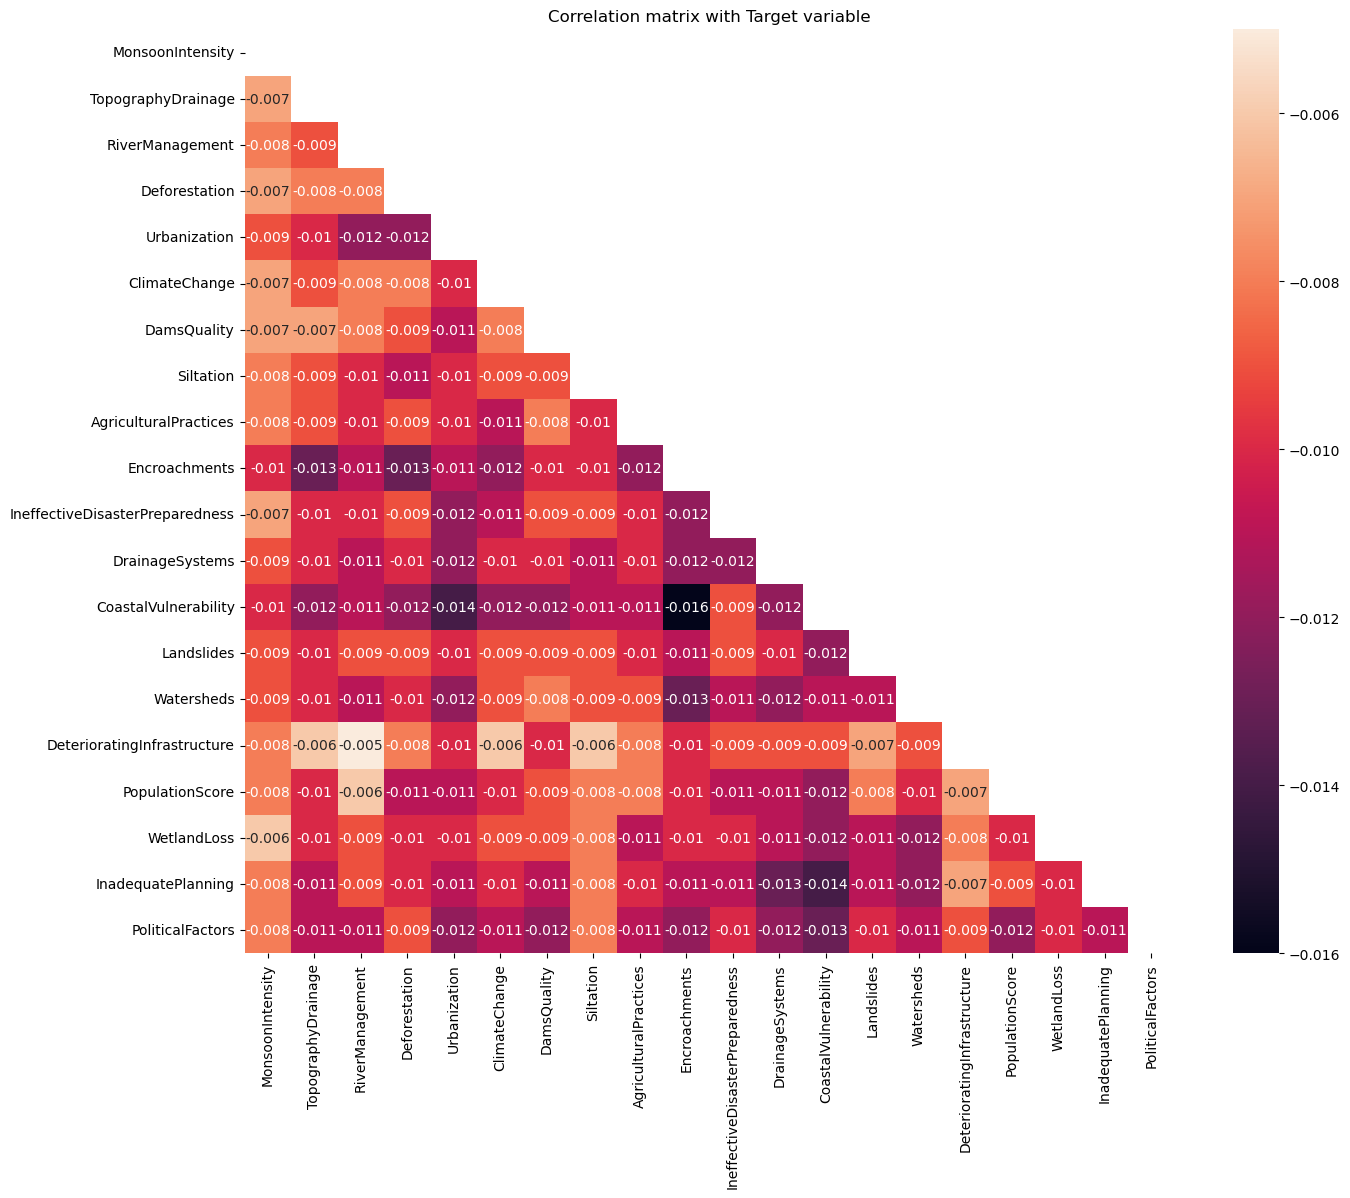

In [17]:
no_target_df = df.drop('FloodProbability', axis=1)
without_target_corr_matrix = no_target_df.corr() # Default is Pearson

# Create a mask for the upper triangle
mask_up_tri = np.triu(np.ones_like(without_target_corr_matrix, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(without_target_corr_matrix.round(3), annot=True, mask=mask_up_tri)
plt.title("Correlation matrix with Target variable")
plt.show()

In [18]:
# Calculate the correlation matrix with target
df.corr().abs()["FloodProbability"].sort_values(ascending=False)

FloodProbability                   1.000
DeterioratingInfrastructure        0.192
MonsoonIntensity                   0.190
DamsQuality                        0.190
TopographyDrainage                 0.189
RiverManagement                    0.189
Siltation                          0.188
PopulationScore                    0.188
Landslides                         0.187
ClimateChange                      0.186
Deforestation                      0.185
WetlandLoss                        0.185
AgriculturalPractices              0.185
IneffectiveDisasterPreparedness    0.185
PoliticalFactors                   0.184
Watersheds                         0.184
InadequatePlanning                 0.183
Urbanization                       0.183
DrainageSystems                    0.181
Encroachments                      0.180
CoastalVulnerability               0.179
Name: FloodProbability, dtype: float64

## Target

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


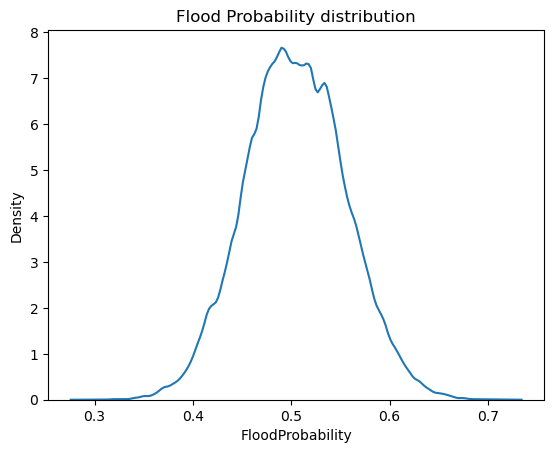

In [19]:
sns.kdeplot(data=df, x="FloodProbability")
plt.title("Flood Probability distribution")
plt.show()

# Pre-processing

In [21]:
features = df.drop('FloodProbability', axis=1)
target = df['FloodProbability']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.1, random_state=SEED, shuffle=True
)

# Check the shape of the train and test data
print(f"Train data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

Train data shape: (1051161, 20), (1051161,)
Test data shape: (116796, 20), (116796,)


# Feature engineering

# Metric

# Modeling

In [38]:
lgbm_params = {
    'objective': 'regression',           
    #'metric': 'auc',                 
    #'device_type': 'gpu',            
    'random_state': SEED,            
    'verbosity': -1,                 
    'num_threads': -1
}

xgb_params = {
    'objective': 'reg:squarederror',
    #'eval_metric': 'auc',
    #'device': 'gpu',    
    'random_state': SEED,
}

cat_clf = CatBoostRegressor(
    #task_type='GPU',
    random_state=SEED,
    loss_function='RMSE',
    eval_metric='R2',
    early_stopping_rounds=10,
    verbose=False)

In [27]:
%%time

# Cross-validation split
kfold = KFold(n_splits=10, shuffle=True, random_state=SEED)

r2_scores = []
for train_index, valid_index in tqdm(kfold.split(X_train, y_train), total=kfold.get_n_splits(), desc='K-Fold Progress'):
    train_data = lgb.Dataset(data=X_train.iloc[train_index], label=y_train.iloc[train_index])
    valid_data = lgb.Dataset(data=X_train.iloc[valid_index], label=y_train.iloc[valid_index])

    # Train the model
    gbm = lgb.train(
        lgbm_params,
        train_data,
        num_boost_round=100,
        valid_sets=[train_data, valid_data],
        valid_names=['train', 'valid'],
        callbacks=[lgb.early_stopping(stopping_rounds=10)]
    )
    
    y_pred = gbm.predict(X_train.iloc[valid_index], num_iteration=gbm.best_iteration)

    # Calculate R2 and store the score
    r2 = r2_score(y_train.iloc[valid_index], y_pred)
    r2_scores.append(r2)

# Output the mean R2
print(f'\nMean R2: {np.mean(r2_scores)}\n')

K-Fold Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds


K-Fold Progress:  10%|█         | 1/10 [00:02<00:24,  2.74s/it]

Did not meet early stopping. Best iteration is:
[100]	train's l2: 0.000576756	valid's l2: 0.000588393
Training until validation scores don't improve for 10 rounds


K-Fold Progress:  20%|██        | 2/10 [00:05<00:20,  2.60s/it]

Did not meet early stopping. Best iteration is:
[100]	train's l2: 0.000577419	valid's l2: 0.000586011
Training until validation scores don't improve for 10 rounds


K-Fold Progress:  30%|███       | 3/10 [00:07<00:18,  2.58s/it]

Did not meet early stopping. Best iteration is:
[100]	train's l2: 0.000576417	valid's l2: 0.000594635
Training until validation scores don't improve for 10 rounds


K-Fold Progress:  40%|████      | 4/10 [00:10<00:15,  2.57s/it]

Did not meet early stopping. Best iteration is:
[100]	train's l2: 0.000576884	valid's l2: 0.000593735
Training until validation scores don't improve for 10 rounds


K-Fold Progress:  50%|█████     | 5/10 [00:12<00:12,  2.55s/it]

Did not meet early stopping. Best iteration is:
[100]	train's l2: 0.000575379	valid's l2: 0.000589862
Training until validation scores don't improve for 10 rounds


K-Fold Progress:  60%|██████    | 6/10 [00:15<00:10,  2.55s/it]

Did not meet early stopping. Best iteration is:
[100]	train's l2: 0.000576363	valid's l2: 0.000591829
Training until validation scores don't improve for 10 rounds


K-Fold Progress:  70%|███████   | 7/10 [00:18<00:07,  2.59s/it]

Did not meet early stopping. Best iteration is:
[100]	train's l2: 0.00057697	valid's l2: 0.000593062
Training until validation scores don't improve for 10 rounds


K-Fold Progress:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

Did not meet early stopping. Best iteration is:
[100]	train's l2: 0.000576339	valid's l2: 0.000590091
Training until validation scores don't improve for 10 rounds


K-Fold Progress:  90%|█████████ | 9/10 [00:23<00:02,  2.69s/it]

Did not meet early stopping. Best iteration is:
[100]	train's l2: 0.000577994	valid's l2: 0.000590894
Training until validation scores don't improve for 10 rounds


K-Fold Progress: 100%|██████████| 10/10 [00:27<00:00,  2.79s/it]

Did not meet early stopping. Best iteration is:
[100]	train's l2: 0.000576965	valid's l2: 0.000595142

Mean R2: 0.7724245817721804

CPU times: user 1min 43s, sys: 8.26 s, total: 1min 52s
Wall time: 28 s


In [29]:
%%time

# Cross-validation split
kfold = KFold(n_splits=10, shuffle=True, random_state=SEED)

r2_scores = []
for train_index, valid_index in tqdm(kfold.split(X_train, y_train), total=kfold.get_n_splits(), desc='K-Fold Progress'):
    # Create DMatrix for training and validation sets with appropriate weights
    dtrain = xgb.DMatrix(data=X_train.iloc[train_index], label=y_train.iloc[train_index])
    dvalid = xgb.DMatrix(data=X_train.iloc[valid_index], label=y_train.iloc[valid_index])

    # Train the model
    bst = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=100,
        evals=[(dvalid, 'validation')],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    # Predict probabilities for the validation set
    y_pred = bst.predict(dvalid)

    # Calculate R2 and store the score
    r2 = r2_score(y_train.iloc[valid_index], y_pred)
    r2_scores.append(r2)

# Output the mean R2
print(f'\nMean R2: {np.mean(r2_scores)}\n')

K-Fold Progress: 100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


Mean R2: 0.8153332000407035

CPU times: user 2min, sys: 27.9 s, total: 2min 28s
Wall time: 24.5 s


In [39]:
%%time

# Cross-validation split
kfold = KFold(n_splits=10, shuffle=True, random_state=SEED)

r2_scores = []
for train_index, valid_index in tqdm(kfold.split(X_train, y_train), total=kfold.get_n_splits(), desc='K-Fold Progress'):
    X_train_split, X_valid_split = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_split, y_valid_split = y_train.iloc[train_index], y_train.iloc[valid_index]

    # Train the model
    cat_clf.fit(X_train_split, y_train_split, 
                eval_set=(X_valid_split, y_valid_split),
                use_best_model=True)

    # Predict probabilities for the validation set
    y_pred = cat_clf.predict(X_valid_split)

    # Calculate R2 and store the score
    r2 = r2_score(y_valid_split, y_pred)
    r2_scores.append(r2)

# Output the mean R2
print(f'\nMean R2: {np.mean(r2_scores)}\n')

K-Fold Progress: 100%|██████████| 10/10 [05:03<00:00, 30.38s/it]


Mean R2: 0.8500246556457682

CPU times: user 21min 51s, sys: 58.2 s, total: 22min 49s
Wall time: 5min 3s


# Evaluation

In [40]:
cat_clf.fit(X_train, y_train)
y_pred_cat = cat_clf.predict(X_test)
r2_cat = r2_score(y_test, y_pred_cat)
print(f'CatBoost R2: {r2_cat}')

CatBoost R2: 0.8498795728021463


# Prediction & Submission

In [41]:
# Retrain before prediction
cat_clf.fit(features, target)

# Predict the target variable
test = pd.read_csv(DATA_DIR + 'test.csv')
predictions = cat_clf.predict(test.drop('id', axis=1))

In [42]:
sub = pd.read_csv(DATA_DIR + 'sample_submission.csv')
sub['FloodProbability'] = predictions
sub.to_csv('submission.csv', index=False)

# Test Autogluon

In [20]:
""" 0.85831 
label = "FloodProbability"
predictor = TabularPredictor(label=label).fit(df)

test = pd.read_csv(DATA_DIR + 'test.csv')
predictions = predictor.predict(test.drop('id', axis=1))

sub = pd.read_csv(DATA_DIR + 'sample_submission.csv')
sub[label] = predictions
sub.to_csv('submission.csv', index=False)
"""

' 0.85831 \nlabel = "FloodProbability"\npredictor = TabularPredictor(label=label).fit(df)\n\ntest = pd.read_csv(DATA_DIR + \'test.csv\')\npredictions = predictor.predict(test.drop(\'id\', axis=1))\n\nsub = pd.read_csv(DATA_DIR + \'sample_submission.csv\')\nsub[label] = predictions\nsub.to_csv(\'submission.csv\', index=False)\n'

# Reference